In [2]:
import torch
import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors
named_colors = dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS)

from sklearn.utils.linear_assignment_ import linear_assignment
from envs import mwm2D_task

%matplotlib inline

In [3]:
# 5
#actor_path = os.path.join('results', 'models', 'mwm2D', 'spg', 'siamese', '5a7a10a32807f11b7248df37', 'actor-epoch-5.pt')
# 9
actor_path = os.path.join('results', 'models', 'mwm2D', 'spg', 'siamese', '5a7acabc2807f11b7248df53', 'actor-epoch-7.pt')
# 7 - perfect - RS 520; 5 - 1260
actor_path = os.path.join('results', 'models', 'mwm2D', 'spg', 'siamese', '5a7a4d242807f11b7248df3e', 'actor-epoch-5.pt')

N = 7

actor = torch.load(actor_path, map_location=lambda storage, loc: storage)
actor.use_cuda = False
actor = actor.cpu()

In [4]:
best_random_seed = 200
most_matches = 0
#for ii in range(1000,2000):
torch.manual_seed(1260)
sample = torch.FloatTensor(4, N).uniform_(0, 1)
#print(sample)
#print('--')
# Compute optimal
x_ = sample.numpy()
# compute reward matrix C to maximize
C = np.zeros((N,N))
for i in range(N):
    for j in range(N):
        C[i,j] = np.linalg.norm(x_[2:4, i] - x_[0:2, j], ord=2)   
mm = linear_assignment(-C)
weight = np.sum(C[mm[:,0], mm[:,1]])
#print(mm, weight)

g1 = torch.t(sample[0:2, :])
g2 = torch.t(sample[2:4, :])
sample = torch.cat([g1, g2], dim=0).unsqueeze(0)
#print(sample)
sample = torch.autograd.Variable(sample, volatile=True)

_, perm, _, _, _ = actor.forward(sample)

# # convert perm to a matching
# actor_mm = np.zeros((N,2))
# tmp = np.expand_dims(np.arange(N), 0)
# matches = 0
# for i in range(N):
#     actor_mm[i,0] = i
#     for j in range(N):
#         if perm[:,j,i].data[0] == 1:
#             actor_mm[i,1] = j
#             if mm[i,1] == actor_mm[i,1]:
#                 matches += 1
# if matches > most_matches:
#     most_matches = matches
#     best_random_seed = ii
# print(most_matches, best_random_seed)

matchings = torch.matmul(torch.transpose(sample[:,N:2*N,:], 1, 2), perm)
matchings = torch.transpose(matchings, 1, 2)
matchings = torch.cat([sample[:,0:N,:], matchings], dim=1)

R = mwm2D_task.reward(matchings, False)
print(matchings, R, perm)

Variable containing:
(0 ,.,.) = 
  0.3895  0.7505
  0.9996  0.9188
  0.3437  0.8210
  0.0458  0.3707
  0.9510  0.2439
  0.9082  0.4618
  0.5925  0.4493
  0.8089  0.3194
  0.7432  0.2697
  0.0997  0.2879
  0.9273  0.9443
  0.1422  0.8822
  0.5126  0.7157
  0.1411  0.9818
[torch.FloatTensor of size 1x14x2]
 Variable containing:
 5.1358
[torch.FloatTensor of size 1x1]
 Variable containing:
(0 ,.,.) = 
   0   0   0   1   0   0   0
   0   0   0   0   0   0   1
   0   0   0   0   0   1   0
   1   0   0   0   0   0   0
   0   1   0   0   0   0   0
   0   0   0   0   1   0   0
   0   0   1   0   0   0   0
[torch.FloatTensor of size 1x7x7]



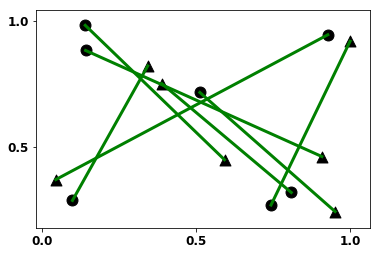

In [5]:
fig, ax = plt.subplots()
# Let's plot the original points
plt.scatter(x_[0,:], x_[1,:], c=named_colors['black'], marker='^', s=120)
plt.scatter(x_[2,:], x_[3,:], c=named_colors['black'], marker='o', s=120)

plt.xticks([0., 0.5, 1.], fontweight='bold')
plt.yticks([0., 0.5, 1.], fontweight='bold')
ax.tick_params(labelsize='large')
# Now connect them with optimal matching
xs_optimal = []
ys_optimal = []
for i in range(N):
    xs_optimal.append([x_[0,i], x_[2, mm[i,1]]])
    ys_optimal.append([x_[1,i], x_[3, mm[i,1]]])
    plt.plot(xs_optimal[-1], ys_optimal[-1], '-', c='g', linewidth=3)
plt.savefig('MWM_7_optimal.png', dpi=300)

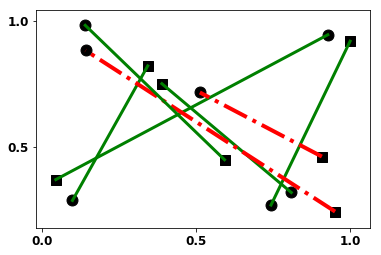

In [6]:
fig, ax = plt.subplots()

# Let's plot the original points
plt.scatter(x_[0,:], x_[1,:], c=named_colors['black'], marker='^', s=120)
plt.scatter(x_[2,:], x_[3,:], c=named_colors['black'], marker='o', s=120)
plt.xticks([0., 0.5,  1.], fontweight='bold')
plt.yticks([0., 0.5, 1.], fontweight='bold')
ax.tick_params(labelsize='large')
matchings = matchings.squeeze()
for i in range(N):
    xs = [matchings[i,0].data[0], matchings[i+N,0].data[0]]
    ys = [matchings[i,1].data[0], matchings[i+N,1].data[0]]
    if xs_optimal[i] == xs and ys_optimal[i] == ys:
        plt.plot(xs, ys, '-', c='g', linewidth=3)
    else:
        plt.plot(xs, ys, '-.', c='r', linewidth=4)
fig.savefig('MWM_7_SPG.png', dpi=200)